In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import regex as re
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import time

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('final.csv')
df.head()

,author,id,selftext,title,subreddit_tifu,text,line_count
0,Funguy0623,cafv59,This LITERALLY just happened. I was on the pho...,TIFU by accidentally causing a cat to get run ...,1,TIFU by accidentally causing a cat to get run ...,2
1,Throwaway678495,82vog8,"So unlike many of the stories here, this one d...",TIFU by getting a girls phone number,1,TIFU by getting a girls phone number So unlike...,2
2,capj23,c3lqoh,"Obligatory, this happened 14 years ago and I w...",TIFU by climbing too far on my uncle,1,TIFU by climbing too far on my uncle Obligator...,8
3,dognass,cacjwi,"Right not sure how to go about this, but here ...",TIFU Dog and Ass,1,TIFU Dog and Ass Right not sure how to go abou...,16
4,SourBitchKids,caj1fz,I recently came into the possession of a new k...,TIFU by smoking too much weed and going into a...,1,TIFU by smoking too much weed and going into a...,4


In [3]:
X = df['text']
y = df['subreddit_tifu']

In [4]:
stops = stopwords.words("ENGLISH")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

## My first model. It got such good results that I wanted to see what else I could do

In [6]:
#figure out the proper parameters for CountVectorizer before I wrap it in a couple of other models
params_cvec = {
    'cvec__max_features': [100,200,300,400,500,600,700],
    'cvec__stop_words': [stops, None],
    'cvec__ngram_range': [(1,1), (1,2)]
}
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('tree', DecisionTreeClassifier(random_state = 42))])
grid_cvec = GridSearchCV(pipe_cvec, param_grid = params_cvec, n_jobs = -1, verbose = True, cv = 5)
grid_cvec.fit(X_train, y_train)
print(grid_cvec.best_score_)
grid_cvec.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   29.9s finished


0.9961111111111111


{'cvec__max_features': 500,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in'

In [7]:
grid_cvec.score(X_test, y_test)

1.0

In [8]:
pred_cvec = grid_cvec.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred_cvec), columns = ['pred nsq', 'pred tifu'], index = ['actual nsq', 'actual tifu'])


,pred nsq,pred tifu
actual nsq,300,0
actual tifu,0,300


### I wanted to make two models showing different things. Every post on r/tifu starts with...TIFU. I wanted to know if the model would do as well if I removed that from everything and redid it.

In [9]:
X_no_tifu = X.str.replace('TIFU', '')
X_no_tifu = X_no_tifu.str.replace('Tifu', '')
X_no_tifu = X_no_tifu.str.replace('tifu', '')
X_no_tifu = X_no_tifu.str.replace('by', '')
X_no_tifu = X_no_tifu.str.replace('By', '')

In [10]:
X_no_tifu[1837]

'Is there a website where I can find out about all the Australian Aboriginal soldiers who fought in both the Second World War and the Korean War? '

In [11]:
X_no_tifu.sample(35)

100       making everyone in the elevator think that t...
1693    What are the socially accepted timespans to na...
41        saying a stupid word at work So this did act...
876       being a virgin and having practice sex with ...
171       making my wife think I fancy my mother. Obli...
1920    How did Noah keep all the animals under contro...
1543    Is there a word that means that something you'...
1521    Could a human survive if their body from their...
1267    My brother died in a power line accident, did ...
2006    How can anyone deny climate change when it's o...
2335    If the biological purpose of sex and attractio...
690       having my roomate walk in while I was practi...
348       not understanding that 3.5 grams can be a fu...
2124    Female human have period. Why don't female cat...
745       ingesting my bf's chemo Figured it out today...
836       accidentally being overly sexual to my cowor...
614      because I disappointet my very best friend fo...
675       acci

In [12]:
X_train_no_tifu, X_test_no_tifu, y_train_no_tifu, y_test_no_tifu = train_test_split(X_no_tifu,y,random_state = 42, stratify = y)

## Spent a while tuning parameters, as one does

In [13]:

params_cvec = {
    'cvec__max_features': [70,170,270,370],
    'cvec__ngram_range': [(1,1), (1,2)],
    'tree__max_depth': [40,50,60],
    'tree__min_samples_split': [5,6,7],
    'tree__min_samples_leaf': [1,2,3,4]
}
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('tree', DecisionTreeClassifier(random_state = 42))])
grid_cvec = GridSearchCV(pipe_cvec, param_grid = params_cvec, n_jobs = -1, verbose = True, cv = 5)
grid_cvec.fit(X_train_no_tifu, y_train_no_tifu)
print(grid_cvec.best_score_)
grid_cvec.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.2min finished


0.9638888888888889


{'cvec__max_features': 370,
 'cvec__ngram_range': (1, 1),
 'tree__max_depth': 40,
 'tree__min_samples_leaf': 3,
 'tree__min_samples_split': 5}

In [14]:
grid_cvec.score(X_test_no_tifu, y_test_no_tifu)

0.9716666666666667

In [15]:
pipe_final = Pipeline([('cvec', CountVectorizer(max_features = 270, 
                                                ngram_range = (1,1), 
                                                stop_words = stops)),
                      ('tree', DecisionTreeClassifier(max_depth = 60, 
                                                      min_samples_leaf = 3, 
                                                      min_samples_split = 6, 
                                                      random_state = 42))])
pipe_final.fit(X_train_no_tifu, y_train_no_tifu)
pipe_final.score(X_test_no_tifu, y_test_no_tifu)

0.9783333333333334

## Getting the relevant features from the model

In [16]:
pipe_final['tree'].feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.05723929e-05, 0.00000000e+00, 2.27040578e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.10066538e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.26867372e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.40553609e-01, 0.00000000e+00, 1.58374920e-04,
      

In [17]:
pipe_final['tree'].n_features_

270

In [18]:
pipe_final['cvec'].vocabulary_

{'trying': 240,
 'probably': 178,
 'started': 210,
 'yesterday': 269,
 'today': 234,
 '10': 0,
 'instead': 121,
 'decided': 48,
 'would': 263,
 'get': 85,
 'done': 51,
 'got': 94,
 'well': 256,
 'go': 90,
 'give': 89,
 'look': 137,
 'find': 73,
 'first': 74,
 'hear': 105,
 'one': 167,
 'guy': 97,
 'say': 192,
 'something': 207,
 'says': 194,
 'let': 131,
 'know': 126,
 'little': 134,
 'think': 226,
 'much': 154,
 'wife': 259,
 'comes': 39,
 'guys': 98,
 'door': 52,
 'start': 209,
 'used': 245,
 'making': 144,
 'even': 61,
 'car': 34,
 'lot': 140,
 'best': 25,
 'found': 75,
 'etc': 60,
 'still': 211,
 'tl': 232,
 'dr': 53,
 'tried': 238,
 'take': 217,
 'could': 42,
 'make': 143,
 'edit': 54,
 'since': 202,
 'many': 146,
 'people': 171,
 'story': 213,
 'https': 117,
 'com': 37,
 'basically': 22,
 'felt': 71,
 'way': 252,
 'use': 244,
 'talking': 220,
 'another': 11,
 'also': 8,
 'seen': 197,
 'idea': 118,
 'guess': 96,
 'move': 153,
 'things': 225,
 'thanks': 223,
 'looked': 138,
 'girl'

In [19]:
dic = pipe_final['cvec'].vocabulary_
word_df = pd.DataFrame()
word_df['words'] = dic.keys()
word_df['index'] = dic.values()
word_df['values'] = pipe_final['tree'].feature_importances_
#I know there's supposed to be a better way to do this, but it kept giving it to me wrong if I put it in the instantiation

In [20]:
word_df.head()

,words,index,values
0,trying,240,0.0
1,probably,178,0.0
2,started,210,0.0
3,yesterday,269,0.0
4,today,234,0.0


In [21]:
words_df = word_df.sort_values('values', ascending= False)

In [22]:
words_df.head(25)

,words,index,values
53,story,213,0.640554
233,school,195,0.245419
79,long,136,0.027262
213,mom,149,0.013441
88,anything,13,0.008841
86,friend,76,0.008210
92,oh,164,0.008056
98,bit,28,0.007033
257,everything,65,0.006573
176,hard,103,0.005740


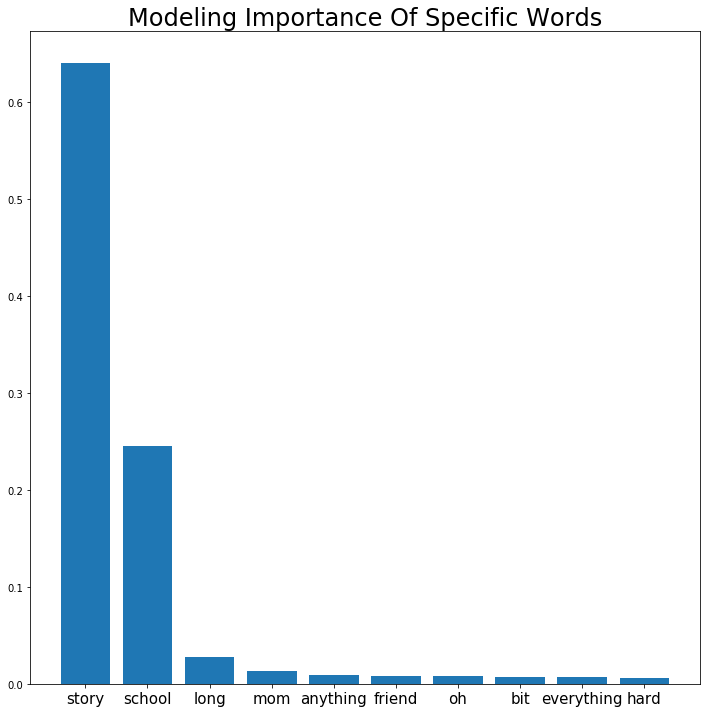

In [23]:
plt.figure(figsize = (12,12), )
plt.title('Modeling Importance Of Specific Words', size = 24)
plt.bar(words_df['words'].head(10), words_df['values'].head(10))
plt.xticks(size = 15);

In [24]:
pred_tree = pipe_final.predict(X_test_no_tifu)
pd.DataFrame(confusion_matrix(y_test, pred_tree), columns = ['pred nsq', 'pred tifu'], index = ['actual nsq', 'actual tifu'])


,pred nsq,pred tifu
actual nsq,294,6
actual tifu,7,293


## Let's try Bayesian

In [25]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

In [26]:
params_bayes = {
    'cvec__max_features': [70,170,270,370],
    'cvec__ngram_range': [(1,1), (1,2)],
    'multi__alpha': np.logspace(-10,-5,100)
}
pipe_bern = Pipeline([('cvec', CountVectorizer(stop_words = stops)),
                      ('multi', BernoulliNB())])
grid_bern = GridSearchCV(pipe_bern, param_grid = params_bayes, n_jobs = -1, verbose = True, cv = 5)
grid_bern.fit(X_train_no_tifu, y_train_no_tifu)


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 12.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [27]:
print(grid_bern.best_score_)
print(grid_bern.score(X_test_no_tifu, y_test_no_tifu))
grid_bern.best_params_

0.9661111111111111
0.9683333333333334


{'cvec__max_features': 270,
 'cvec__ngram_range': (1, 1),
 'multi__alpha': 2.310129700083158e-09}

In [28]:
pipe_bern = Pipeline([('cvec', CountVectorizer(max_features = 270, ngram_range = (1,1), stop_words = stops)),
                      ('multi', BernoulliNB(alpha = 2.310129700083158e-09))])
pipe_bern.fit(X_train_no_tifu, y_train_no_tifu)
pipe_bern.score(X_test_no_tifu, y_test_no_tifu)

0.9683333333333334

In [29]:
pred_bern = pipe_bern.predict(X_test_no_tifu)
pd.DataFrame(confusion_matrix(y_test, pred_bern), columns = ['pred nsq', 'pred tifu'], index = ['actual nsq', 'actual tifu'])


,pred nsq,pred tifu
actual nsq,288,12
actual tifu,7,293
